In [14]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
from time import time
from tqdm import tqdm
import datetime as dt
from collections import Counter

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing
from lda_functions import party_substituter, sparse_text_nostemmer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [5]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# LDA using gensim 

- take only with certin 'tags' from clean text: nouns, verbs, adverbs, adjectives
    - substitute parties acronyms (SPD: sozialdemokraten, CDU: christdemokraten, CSU: christoziale, FDP: freidemokraten, Afd: pfannen(unfortunately, using 'alternative' as substitute might intervene with the commonly used word or even with the politically more leftist alternatives that are not quite punks yet; using some cooking tool should be save)) 
    - make them lower-case
    - take only words longer than 2 characters
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
- run through a couple of topics numbers and look at metrics: coherence score and model perplexity
    -> chose number of topics where metrics look best
- run lda on corpus, evaluate model and visualize it

In [8]:
save = True

path_com_corpus = '../Data/lda_nlp_ccorpus.pkl'
path_corpus = '../Data/lda_nlp_corpus'
path_dic = '../Data/lda_nlp_dic.pkl'

if save:
    text = all_data.loc[:, 'clean_text'].map(lambda x: x.lower()).map(party_substituter)

    document = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
    
    lengths = len(document)
    corpus = []
    tick = time()
    for i, term in enumerate(document):
        corpus.append(sparse_text_nostemmer(term, nlp))
        print('{}/{}'.format(i, lengths), end='\r')
        if i % 5000 == 0:
            t1 = (time() - tick)/60
            print('Took {:.2f} min for {} loops'.format(t1, i))
    print('The entire process took {:.2f} min'.format((time() - tick)/60))

    common_dictionary = corpora.Dictionary(corpus, prune_at=100000)

    common_corpus = [common_dictionary.doc2bow(row) for row in corpus]
    
    with open(path_com_corpus, 'wb') as fid:
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)       

else:
    with open(path_com_corpus, 'rb') as fid:
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)

Took 0.00 min for 0 loops
Took 0.62 min for 1000 loops
Took 1.35 min for 2000 loops
Took 1.99 min for 3000 loops
Took 2.55 min for 4000 loops
Took 3.23 min for 5000 loops
Took 3.79 min for 6000 loops
Took 4.36 min for 7000 loops
Took 4.96 min for 8000 loops
Took 5.48 min for 9000 loops
Took 6.04 min for 10000 loops
Took 6.52 min for 11000 loops
Took 7.15 min for 12000 loops
Took 7.82 min for 13000 loops
Took 8.36 min for 14000 loops
Took 8.84 min for 15000 loops
Took 9.40 min for 16000 loops
Took 10.01 min for 17000 loops
Took 10.58 min for 18000 loops
Took 11.05 min for 19000 loops
Took 11.52 min for 20000 loops
Took 12.15 min for 21000 loops
Took 12.67 min for 22000 loops
Took 13.22 min for 23000 loops
Took 13.71 min for 24000 loops
Took 14.35 min for 25000 loops
Took 14.84 min for 26000 loops
Took 15.46 min for 27000 loops
Took 15.95 min for 28000 loops
Took 16.54 min for 29000 loops
Took 17.10 min for 30000 loops
Took 17.56 min for 31000 loops
Took 18.00 min for 32000 loops
Took 18

At 80 of 100
At 82 of 100
At 84 of 100
At 86 of 100
At 88 of 100
At 90 of 100
At 92 of 100


/home/franzi/miniconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



At 94 of 100
At 96 of 100
At 98 of 100
Process took 18.899526131153106 min


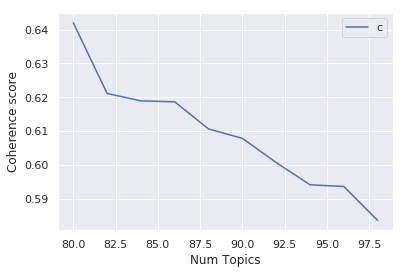

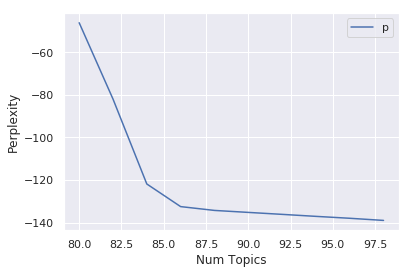

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    tick = time()
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.2,
                       iterations=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(common_corpus))
        print('At {} of {}'.format(num_topics, limit))
    print('Process took {} min'.format((time()-tick)/60))
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    plt.plot(x, perplexity_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity")
    plt.legend(("perplexity"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=100, start=80, step=2)

Following from coherence score curve
- choose 22 topics: highest coherence score before curve flattens out 
- given the corpus 20 topics make more sense than 80 - this can also be seen in the LDA visualization: with 80 topics, most of them cluster in the lower-right corner

Following from LDA visualization
- comparing topic-bubbles of different numbers of topics: chosing 17 topics results in nicely distributed, hardly overlapping clusters

In [11]:
lda = LdaModel(common_corpus, 
               num_topics=83, 
               id2word=common_dictionary, 
               alpha=0.001, 
               random_state=123, 
               minimum_probability=0.2,
               per_word_topics=True)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score c_v:  0.6206530736110548
Coherence Score u-mass:  -18.291130563286178
Model perplexity:  -106.05739454012146


/home/franzi/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = texts
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: cannot concatenate object of type "<class 'list'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid